# Introduction
I am a physician and studying medical AI and data science. This time I tried object detection in chest X-ray images. There are 8 types of clinical findings, such as infiltration, atelectasis, effusion, mass, nodule, cardiomegaly, etc. Particularly, detection of mass and nodule is clinically very important, because mass or nodule on a chest X-ray image suggests possiblity of lung cancer. In many cases, patients having lung cancer have no symptom at an early stage. Thus, mass or nodule is found by coincidence on a chest X-ray image and lung cancer is suspected. Then, the final diagnosis is often made with CT. Therefore, mass or nodule must not be overlooked, and AI is expected to support physician or radiologist with finding mass or nodule without fail.

# Import Libraries and Upload CSV File
At first, import necessary libraries and the csv file to describe all the chest X-ray images in the dataset. Please note that they are generally made for the classification task purpose, and only some of them have information for object detection task (bounding box).

In [1]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob 
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
all_xray_df = pd.read_csv('../input/data/Data_Entry_2017.csv')
all_xray_df.sample(5)

Image Index                      Finding Labels  Follow-up #  \
67818   00016762_001.png                          No Finding            1   
15468   00004048_000.png                          No Finding            0   
72555   00017879_000.png                          No Finding            0   
102932  00027441_005.png  Effusion|Infiltration|Pneumothorax            5   
10883   00002827_000.png                          No Finding            0   

        Patient ID  Patient Age Patient Gender View Position  \
67818        16762           64              M            PA   
15468         4048           20              M            PA   
72555        17879           27              F            PA   
102932       27441           11              F            AP   
10883         2827           27              M            AP   

        OriginalImage[Width  Height]  OriginalImagePixelSpacing[x     y]  \
67818                  2992     2991                        0.143  0.143   
15468                  2992     2991                        0.143  0.143   
72555                  2992     2991                        0.143  0.143   
102932                 2512     2440                        0.139  0.139   
10883                  2500     2048                        0.168  0.168   

        Unnamed: 11  
67818           NaN  
15468           NaN  
72555           NaN  
102932          NaN  
10883           NaN

In [2]:
all_xray_df['Finding Labels'].values

array(['Cardiomegaly', 'Cardiomegaly|Emphysema', 'Cardiomegaly|Effusion',
       ..., 'No Finding', 'No Finding', 'No Finding'], dtype=object)

In [3]:
# all_xray_df['Finding Labels'].values.tolist()

In [4]:
# set(all_xray_df['Finding Labels'].values.tolist())

In [5]:
len(set(all_xray_df['Finding Labels'].values.tolist()))

836

The majority of the data has no finding, that is healthy image. The number of images of each disease depends on each prevalency. Some diseases are often oberserved in many patients. Other diseases are relatively rare.

In [6]:
all_xray_df['Finding Labels'].value_counts()[:15]

No Finding                  60361
Infiltration                 9547
Atelectasis                  4215
Effusion                     3955
Nodule                       2705
Pneumothorax                 2194
Mass                         2139
Effusion|Infiltration        1603
Atelectasis|Infiltration     1350
Consolidation                1310
Atelectasis|Effusion         1165
Pleural_Thickening           1126
Cardiomegaly                 1093
Emphysema                     892
Infiltration|Nodule           829
Name: Finding Labels, dtype: int64

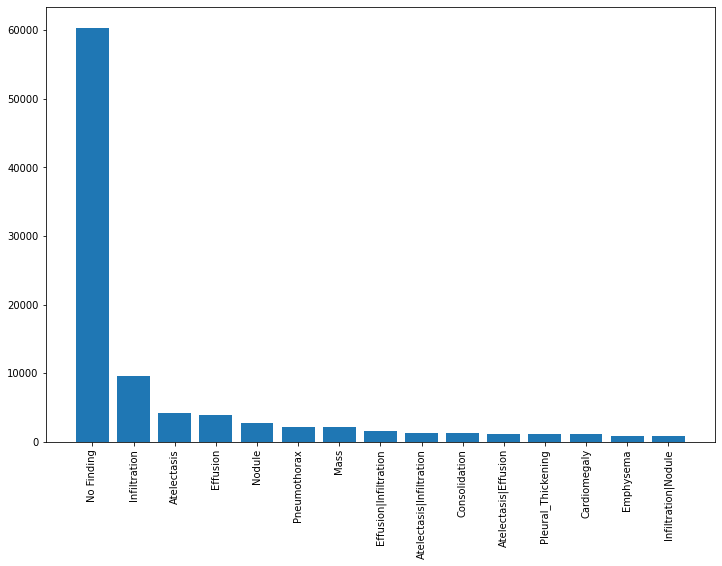

In [7]:
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1, 1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts)) + 0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts)) + 0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In public or medical research, the distribution of data is generally analyzed as to healthy or diseased, female or male, and age. When the data is divided, their distribution must be maintained among the divided sub-data in order to avoid bias.

In [8]:
all_xray_df = pd.read_csv('../input/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'input', 'data',  'images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df['No Finding'] = all_xray_df['Finding Labels'].map(lambda x: 'No Finding' in x)
all_xray_df['Patient Age'] = np.clip(all_xray_df['Patient Age'], 5, 100)
all_xray_df['Patient Male'] = all_xray_df['Patient Gender'].map(lambda x: x.upper() == 'M').astype('float32')
print('The number of samples:', len(all_xray_df))
all_xray_df.sample(5)

Scans found: 112120 , Total Headers 112120
The number of samples: 112120


Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
40226  00010481_029.png     No Finding           29       10481           44   
48630  00012322_009.png     No Finding            9       12322           47   
88541  00021931_001.png   Infiltration            1       21931           64   
78092  00019176_002.png       Effusion            2       19176           67   
56447  00014034_014.png    Atelectasis           14       14034           47   

      Patient Gender View Position  OriginalImage[Width  Height]  \
40226              M            PA                 2974     2721   
48630              M            PA                 2992     2991   
88541              M            PA                 3056     2544   
78092              F            AP                 3056     2544   
56447              M            AP                 2500     2048   

       OriginalImagePixelSpacing[x     y]  Unnamed: 11  \
40226                        0.143  0.143          NaN   
48630                        0.143  0.143          NaN   
88541                        0.139  0.139          NaN   
78092                        0.139  0.139          NaN   
56447                        0.168  0.168          NaN   

                                                   path  No Finding  \
40226  ../input/data/images_005/images/00010481_029.png        True   
48630  ../input/data/images_006/images/00012322_009.png        True   
88541  ../input/data/images_010/images/00021931_001.png       False   
78092  ../input/data/images_009/images/00019176_002.png       False   
56447  ../input/data/images_007/images/00014034_014.png       False   

       Patient Male  
40226           1.0  
48630           1.0  
88541           1.0  
78092           0.0  
56447           1.0

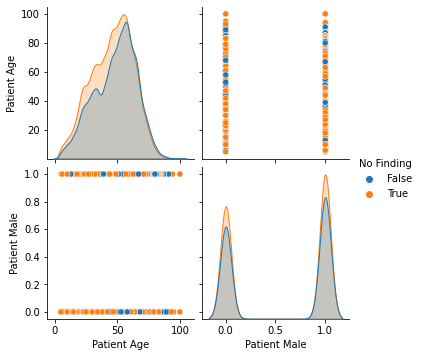

In [9]:
sns.pairplot(all_xray_df[['Patient Age', 'Patient Male', 'No Finding']], hue = 'No Finding')

# Upload CSV File for Object Detection

In [10]:
bbox_list_df = pd.read_csv('/kaggle/input/data/BBox_List_2017.csv')
bbox_list_df.head(5)

Image Index Finding Label     Bbox [x           y           w  \
0  00013118_008.png   Atelectasis  225.084746  547.019217   86.779661   
1  00014716_007.png   Atelectasis  686.101695  131.543498  185.491525   
2  00029817_009.png   Atelectasis  221.830508  317.053115  155.118644   
3  00014687_001.png   Atelectasis  726.237288  494.951420  141.016949   
4  00017877_001.png   Atelectasis  660.067797  569.780787  200.677966   

           h]  Unnamed: 6  Unnamed: 7  Unnamed: 8  
0   79.186441         NaN         NaN         NaN  
1  313.491525         NaN         NaN         NaN  
2  216.949153         NaN         NaN         NaN  
3   55.322034         NaN         NaN         NaN  
4   78.101695         NaN         NaN         NaN

In [11]:
len(bbox_list_df)

984

In [12]:
# bbox_list_df['Finding Label'].values

In [13]:
# bbox_list_df['Finding Label'].values.tolist()

In [14]:
set(bbox_list_df['Finding Label'].values.tolist())

{'Atelectasis',
 'Cardiomegaly',
 'Effusion',
 'Infiltrate',
 'Mass',
 'Nodule',
 'Pneumonia',
 'Pneumothorax'}

In [15]:
len(set(bbox_list_df['Finding Label'].values.tolist()))

8

The number of data is much smaller than that for classification task, because labelling medical data for object detection is more difficult than for classification. It is extremely difficult to find radiologists who can find their time for such labelling. Maybe the number of image data is not sufficient to train an AI model to acquire the satisfactory performance level.

In [16]:
bbox_list_df['Finding Label'].value_counts()

Atelectasis     180
Effusion        153
Cardiomegaly    146
Infiltrate      123
Pneumonia       120
Pneumothorax     98
Mass             85
Nodule           79
Name: Finding Label, dtype: int64

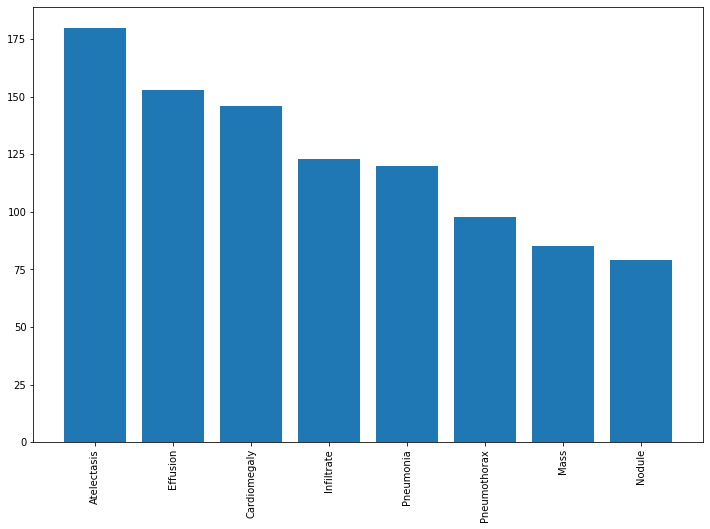

In [17]:
label_counts = bbox_list_df['Finding Label'].value_counts()
fig, ax1 = plt.subplots(1, 1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts)) + 0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts)) + 0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

# Create a CSV File for Object Detection

In [18]:
A = all_xray_df.set_index('Image Index')
A

Finding Labels  Follow-up #  Patient ID  \
Image Index                                                         
00000001_000.png            Cardiomegaly            0           1   
00000001_001.png  Cardiomegaly|Emphysema            1           1   
00000001_002.png   Cardiomegaly|Effusion            2           1   
00000002_000.png              No Finding            0           2   
00000003_000.png                  Hernia            0           3   
...                                  ...          ...         ...   
00030801_001.png          Mass|Pneumonia            1       30801   
00030802_000.png              No Finding            0       30802   
00030803_000.png              No Finding            0       30803   
00030804_000.png              No Finding            0       30804   
00030805_000.png              No Finding            0       30805   

                  Patient Age Patient Gender View Position  \
Image Index                                                  
00000001_000.png           58              M            PA   
00000001_001.png           58              M            PA   
00000001_002.png           58              M            PA   
00000002_000.png           81              M            PA   
00000003_000.png           81              F            PA   
...                       ...            ...           ...   
00030801_001.png           39              M            PA   
00030802_000.png           29              M            PA   
00030803_000.png           42              F            PA   
00030804_000.png           30              F            PA   
00030805_000.png           27              M            PA   

                  OriginalImage[Width  Height]  OriginalImagePixelSpacing[x  \
Image Index                                                                   
00000001_000.png                 2682     2749                        0.143   
00000001_001.png                 2894     2729                        0.143   
00000001_002.png                 2500     2048                        0.168   
00000002_000.png                 2500     2048                        0.171   
00000003_000.png                 2582     2991                        0.143   
...                               ...      ...                          ...   
00030801_001.png                 2048     2500                        0.168   
00030802_000.png                 2048     2500                        0.168   
00030803_000.png                 2048     2500                        0.168   
00030804_000.png                 2048     2500                        0.168   
00030805_000.png                 2048     2500                        0.171   

                     y]  Unnamed: 11  \
Image Index                            
00000001_000.png  0.143          NaN   
00000001_001.png  0.143          NaN   
00000001_002.png  0.168          NaN   
00000002_000.png  0.171          NaN   
00000003_000.png  0.143          NaN   
...                 ...          ...   
00030801_001.png  0.168          NaN   
00030802_000.png  0.168          NaN   
00030803_000.png  0.168          NaN   
00030804_000.png  0.168          NaN   
00030805_000.png  0.171          NaN   

                                                              path  \
Image Index                                                          
00000001_000.png  ../input/data/images_001/images/00000001_000.png   
00000001_001.png  ../input/data/images_001/images/00000001_001.png   
00000001_002.png  ../input/data/images_001/images/00000001_002.png   
00000002_000.png  ../input/data/images_001/images/00000002_000.png   
00000003_000.png  ../input/data/images_001/images/00000003_000.png   
...                                                            ...   
00030801_001.png  ../input/data/images_012/images/00030801_001.png   
00030802_000.png  ../input/data/images_012/images/00030802_000.png   
00030803_000.png  ../input/data/images_012/images/00030803_000.png   
00

In [19]:
B = bbox_list_df.set_index('Image Index')
B

Finding Label     Bbox [x           y           w  \
Image Index                                                          
00013118_008.png   Atelectasis  225.084746  547.019217   86.779661   
00014716_007.png   Atelectasis  686.101695  131.543498  185.491525   
00029817_009.png   Atelectasis  221.830508  317.053115  155.118644   
00014687_001.png   Atelectasis  726.237288  494.951420  141.016949   
00017877_001.png   Atelectasis  660.067797  569.780787  200.677966   
...                        ...         ...         ...         ...   
00029464_015.png   Atelectasis  198.940451  352.900747  615.537778   
00025769_001.png   Atelectasis  701.838229  572.491858  103.537778   
00016837_002.png   Atelectasis  140.913785  658.962969  271.928889   
00020124_003.png   Atelectasis  175.047118  580.456302  244.622222   
00026920_000.png   Atelectasis  343.438229  446.198524  120.604444   

                          h]  Unnamed: 6  Unnamed: 7  Unnamed: 8  
Image Index                                                       
00013118_008.png   79.186441         NaN         NaN         NaN  
00014716_007.png  313.491525         NaN         NaN         NaN  
00029817_009.png  216.949153         NaN         NaN         NaN  
00014687_001.png   55.322034         NaN         NaN         NaN  
00017877_001.png   78.101695         NaN         NaN         NaN  
...                      ...         ...         ...         ...  
00029464_015.png  323.128889         NaN         NaN         NaN  
00025769_001.png   63.715556         NaN         NaN         NaN  
00016837_002.png   94.435556         NaN         NaN         NaN  
00020124_003.png  103.537778         NaN         NaN         NaN  
00026920_000.png   53.475556         NaN         NaN         NaN  

[984 rows x 8 columns]

In [20]:
list_df = B.join(A, how = "inner")
list_df.head(5)

Finding Label     Bbox [x           y           w  \
Image Index                                                          
00000032_037.png    Infiltrate  339.166138  119.195767  172.292063   
00000072_000.png   Atelectasis  356.503704  567.805291  127.864550   
00000147_001.png   Atelectasis  617.650794  599.229630  100.774603   
00000149_006.png   Atelectasis  603.661017  460.239556  249.491525   
00000150_002.png     Pneumonia  601.396825  595.978836  215.635979   

                          h]  Unnamed: 6  Unnamed: 7  Unnamed: 8  \
Image Index                                                        
00000032_037.png  351.085714         NaN         NaN         NaN   
00000072_000.png   82.353439         NaN         NaN         NaN   
00000147_001.png  179.877249         NaN         NaN         NaN   
00000149_006.png   90.033898         NaN         NaN         NaN   
00000150_002.png  180.960847         NaN         NaN         NaN   

                                      Finding Labels  Follow-up #  ...  \
Image Index                                                        ...   
00000032_037.png     Cardiomegaly|Edema|Infiltration           37  ...   
00000072_000.png                         Atelectasis            0  ...   
00000147_001.png                         Atelectasis            1  ...   
00000149_006.png                         Atelectasis            6  ...   
00000150_002.png  Atelectasis|Infiltration|Pneumonia            2  ...   

                  Patient Gender  View Position OriginalImage[Width Height]  \
Image Index                                                                   
00000032_037.png               F             AP                2500    2048   
00000072_000.png               F             PA                2450    2839   
00000147_001.png               F             PA                2742    2948   
00000149_006.png               M             AP                2500    2048   
00000150_002.png               F             AP                3056    2544   

                  OriginalImagePixelSpacing[x     y]  Unnamed: 11  \
Image Index                                                         
00000032_037.png                        0.168  0.168          NaN   
00000072_000.png                        0.143  0.143          NaN   
00000147_001.png                        0.143  0.143          NaN   
00000149_006.png                        0.168  0.168          NaN   
00000150_002.png                        0.139  0.139          NaN   

                                                              path  \
Image Index                                                          
00000032_037.png  ../input/data/images_001/images/00000032_037.png   
00000072_000.png  ../input/data/images_001/images/00000072_000.png   
00000147_001.png  ../input/data/images_001/images/00000147_001.png   
00000149_006.png  ../input/data/images_001/images/00000149_006.png   
00000150_002.png  ../input/data/images_001/images/00000150_002.png   

                  No Finding Patient Male  
Image Index                                
00000032_037.png       False          0.0  
00000072_000.png       False          0.0  
00000147_001.png       False          0.0  
00000149_006.png       False          1.0  
00000150_002.png       False          0.0  

[5 rows x 22 columns]

In [21]:
list_df = list_df.reset_index(drop = False)
list_df.head(5)

Image Index Finding Label     Bbox [x           y           w  \
0  00000032_037.png    Infiltrate  339.166138  119.195767  172.292063   
1  00000072_000.png   Atelectasis  356.503704  567.805291  127.864550   
2  00000147_001.png   Atelectasis  617.650794  599.229630  100.774603   
3  00000149_006.png   Atelectasis  603.661017  460.239556  249.491525   
4  00000150_002.png     Pneumonia  601.396825  595.978836  215.635979   

           h]  Unnamed: 6  Unnamed: 7  Unnamed: 8  \
0  351.085714         NaN         NaN         NaN   
1   82.353439         NaN         NaN         NaN   
2  179.877249         NaN         NaN         NaN   
3   90.033898         NaN         NaN         NaN   
4  180.960847         NaN         NaN         NaN   

                       Finding Labels  ...  Patient Gender  View Position  \
0     Cardiomegaly|Edema|Infiltration  ...               F             AP   
1                         Atelectasis  ...               F             PA   
2                         Atelectasis  ...               F             PA   
3                         Atelectasis  ...               M             AP   
4  Atelectasis|Infiltration|Pneumonia  ...               F             AP   

   OriginalImage[Width Height] OriginalImagePixelSpacing[x     y]  \
0                 2500    2048                       0.168  0.168   
1                 2450    2839                       0.143  0.143   
2                 2742    2948                       0.143  0.143   
3                 2500    2048                       0.168  0.168   
4                 3056    2544                       0.139  0.139   

   Unnamed: 11                                              path  No Finding  \
0          NaN  ../input/data/images_001/images/00000032_037.png       False   
1          NaN  ../input/data/images_001/images/00000072_000.png       False   
2          NaN  ../input/data/images_001/images/00000147_001.png       False   
3          NaN  ../input/data/images_001/images/00000149_006.png       False   
4          NaN  ../input/data/images_001/images/00000150_002.png       False   

   Patient Male  
0           0.0  
1           0.0  
2           0.0  
3           1.0  
4           0.0  

[5 rows x 23 columns]

In [22]:
list_df = list_df.drop(['Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 11'], axis = 1)
list_df.head(5)

Image Index Finding Label     Bbox [x           y           w  \
0  00000032_037.png    Infiltrate  339.166138  119.195767  172.292063   
1  00000072_000.png   Atelectasis  356.503704  567.805291  127.864550   
2  00000147_001.png   Atelectasis  617.650794  599.229630  100.774603   
3  00000149_006.png   Atelectasis  603.661017  460.239556  249.491525   
4  00000150_002.png     Pneumonia  601.396825  595.978836  215.635979   

           h]                      Finding Labels  Follow-up #  Patient ID  \
0  351.085714     Cardiomegaly|Edema|Infiltration           37          32   
1   82.353439                         Atelectasis            0          72   
2  179.877249                         Atelectasis            1         147   
3   90.033898                         Atelectasis            6         149   
4  180.960847  Atelectasis|Infiltration|Pneumonia            2         150   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           55              F            AP                 2500     2048   
1           67              F            PA                 2450     2839   
2           66              F            PA                 2742     2948   
3           71              M            AP                 2500     2048   
4           55              F            AP                 3056     2544   

   OriginalImagePixelSpacing[x     y]  \
0                        0.168  0.168   
1                        0.143  0.143   
2                        0.143  0.143   
3                        0.168  0.168   
4                        0.139  0.139   

                                               path  No Finding  Patient Male  
0  ../input/data/images_001/images/00000032_037.png       False           0.0  
1  ../input/data/images_001/images/00000072_000.png       False           0.0  
2  ../input/data/images_001/images/00000147_001.png       False           0.0  
3  ../input/data/images_001/images/00000149_006.png       False           1.0  
4  ../input/data/images_001/images/00000150_002.png       False           0.0

In [23]:
list_df.to_csv('BBox List.csv', header = True, index = False)

# Visualize Sample Data

In [24]:
list_df.loc[0, :]

Image Index                                                    00000032_037.png
Finding Label                                                        Infiltrate
Bbox [x                                                              339.166138
y                                                                    119.195767
w                                                                    172.292063
h]                                                                   351.085714
Finding Labels                                  Cardiomegaly|Edema|Infiltration
Follow-up #                                                                  37
Patient ID                                                                   32
Patient Age                                                                  55
Patient Gender                                                                F
View Position                                                                AP
OriginalImage[Width                     

In [25]:
list_df.iloc[0, 2:6]

Bbox [x    339.166138
y          119.195767
w          172.292063
h]         351.085714
Name: 0, dtype: object

In [26]:
list_df.iloc[0, 2:6][0].dtype

dtype('float64')

In [27]:
list_df.loc[0, 'Bbox [x':'h]']

Bbox [x    339.166138
y          119.195767
w          172.292063
h]         351.085714
Name: 0, dtype: object

In [28]:
list_df.iloc[0, 2:6][0] + list_df.iloc[0, 2:6][2]

511.458201058202

In [29]:
list_df.iloc[0, 2:6][1] + list_df.iloc[0, 2:6][3]

470.281481481481

In [30]:
list_df.iloc[0, 12:14]

OriginalImage[Width    2500
Height]                2048
Name: 0, dtype: object

In [31]:
list_df.loc[0, 'OriginalImage[Width':'Height]']

OriginalImage[Width    2500
Height]                2048
Name: 0, dtype: object

In [32]:
list_df.iloc[0, 12:14][0]

2500

In [33]:
list_df.iloc[0, 12:14][0].dtype

dtype('int64')

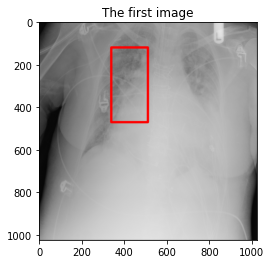

In [34]:
import cv2
image0 = cv2.imread('../input/data/images_001/images/00000032_037.png')
cv2.rectangle(image0, (int(list_df.iloc[0, 2:6][0]), int(list_df.iloc[0, 2:6][1])), (int(list_df.iloc[0, 2:6][0] + list_df.iloc[0, 2:6][2]), int(list_df.iloc[0, 2:6][1] + list_df.iloc[0, 2:6][3])), (255, 0, 0), 10)
plt.title('The first image')
plt.imshow(image0)

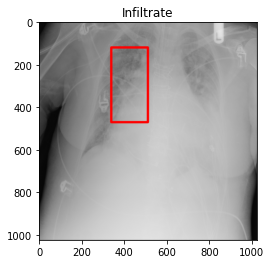

In [35]:
import cv2
image0 = cv2.imread(list_df.loc[0, 'path'])
cv2.rectangle(image0, (int(list_df.iloc[0, 2:6][0]), int(list_df.iloc[0, 2:6][1])), (int(list_df.iloc[0, 2:6][0] + list_df.iloc[0, 2:6][2]), int(list_df.iloc[0, 2:6][1] + list_df.iloc[0, 2:6][3])), (255, 0, 0), 10)
plt.title(list_df.loc[0, 'Finding Label'])
plt.imshow(image0)

Mass and nodule are generally small and similar to each other and often used interchangeably. Pneumothorax (air) appears in the upper part of the lung. Cardiomegaly is the only disease of the heart among the diseases. Atelectasis (no air) can appear anywhere in the lung.

Object Detections in Chest X-Ray


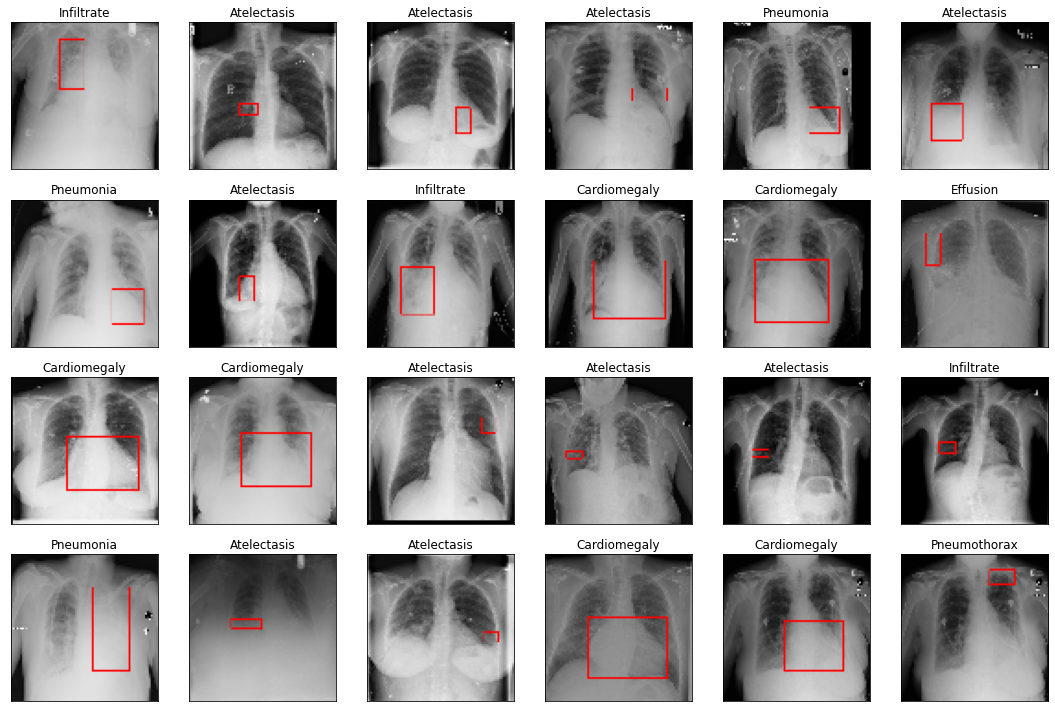

In [36]:
print("Object Detections in Chest X-Ray")
fig, axes = plt.subplots(nrows = 4, ncols = 6, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(list_df.loc[i, 'path'])
    cv2.rectangle(img, (int(list_df.iloc[i, 2:6][0]), int(list_df.iloc[i, 2:6][1])), (int(list_df.iloc[i, 2:6][0] + list_df.iloc[i, 2:6][2]), int(list_df.iloc[i, 2:6][1] + list_df.iloc[i, 2:6][3])), (255, 0, 0), 10)
    img = cv2.resize(img, (80, 80))
    ax.imshow(img)
    ax.set_title(list_df.loc[i, 'Finding Label'])
fig.tight_layout()    

plt.show()

# Create Dataset Composed of Image, Bounding Box, and Label.

In [37]:
import torch
torch.__version__

'1.11.0'

In [38]:
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [39]:
import torchvision
torchvision.__version__

'0.12.0'

In [40]:
from PIL import Image
from torchvision import transforms

In [41]:
images = []
for i in range(len(list_df)):
    image_path = list_df.loc[i, 'path']
    image = Image.open(image_path)
    image = transforms.Compose([transforms.ToTensor() ])(image)
    images.append(image)

In [42]:
images[0:3]

[tensor([[[0.0157, 0.0275, 0.0275,  ..., 0.0863, 0.0941, 0.0549],
          [0.0353, 0.0549, 0.0588,  ..., 0.1765, 0.1882, 0.1137],
          [0.0353, 0.0549, 0.0549,  ..., 0.1725, 0.1804, 0.1059],
          ...,
          [0.3412, 0.6000, 0.5804,  ..., 0.0510, 0.0588, 0.0353],
          [0.3490, 0.6157, 0.5961,  ..., 0.0510, 0.0588, 0.0353],
          [0.1686, 0.2980, 0.2863,  ..., 0.0235, 0.0275, 0.0196]]]),
 tensor([[[0.8627, 0.8549, 0.8627,  ..., 0.6863, 0.8157, 0.4902],
          [0.8627, 0.8627, 0.8471,  ..., 0.6353, 0.7529, 0.4510],
          [0.8549, 0.8706, 0.8431,  ..., 0.6157, 0.7216, 0.4431],
          ...,
          [0.8118, 0.7882, 0.7882,  ..., 0.4392, 0.5490, 0.3294],
          [0.7922, 0.7922, 0.8078,  ..., 0.4510, 0.5529, 0.3373],
          [0.7961, 0.8039, 0.8118,  ..., 0.4510, 0.5373, 0.3294]]]),
 tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.9412, 0.9451, 0.9569],
          [0.0000, 0.0000, 0.0000,  ..., 0.9294, 0.9451, 0.9529],
          [0.0000, 0.0000, 0.0000,  ...,

In [43]:
images[0].shape

torch.Size([1, 1024, 1024])

There are 5 images having abnormal size that must be removed from the dataset.

In [44]:
abnormal = []

for i in range(len(list_df)):
    if images[i].shape != torch.Size([1, 1024, 1024]):
        abnormal.append(i)
        
abnormal

[39, 66, 81, 259, 406]

In [45]:
images[39].shape

torch.Size([4, 1024, 1024])

In [46]:
len(images)

984

In [47]:
images = []
for i in range(len(list_df)):
    if (i != 39) & (i != 66) & (i != 81) & (i != 259) & (i != 406):
        image_path = list_df.loc[i, 'path']
        image = Image.open(image_path)
        image = transforms.Compose([transforms.ToTensor() ])(image)
        images.append(image)

In [48]:
abnormal = []

for i in range(len(images)):
    if images[i].shape != torch.Size([1, 1024, 1024]):
        abnormal.append(i)
        
abnormal

[]

In [49]:
boxes = []
for i in range(len(list_df)):
    if (i != 39) & (i != 66) & (i != 81) & (i != 259) & (i != 406):        
        box = [list_df.iloc[i, 2:6][0], list_df.iloc[i, 2:6][1], list_df.iloc[i, 2:6][0] + list_df.iloc[i, 2:6][2], list_df.iloc[i, 2:6][1] + list_df.iloc[i, 2:6][3]]
        boxes.append([box]) 
                                                                           
boxes = torch.tensor(boxes, dtype = torch.float32) 

In [50]:
boxes

tensor([[[339.1661, 119.1958, 511.4582, 470.2815]],

        [[356.5037, 567.8053, 484.3683, 650.1588]],

        [[617.6508, 599.2296, 718.4254, 779.1069]],

        ...,

        [[612.6934, 459.9846, 836.8356, 593.1046]],

        [[611.9538, 440.5096, 770.1049, 591.8341]],

        [[632.9492, 251.9684, 860.7458, 462.4091]]])

In [51]:
bbox_labels = [
 'Atelectasis',
 'Cardiomegaly',
 'Effusion',
 'Infiltrate',
 'Mass',
 'Nodule',
 'Pneumonia',
 'Pneumothorax']

labels = []
for i in range(len(list_df)):
    if (i != 39) & (i != 66) & (i != 81) & (i != 259) & (i != 406):        
        label = list_df.loc[i, 'Finding Label']
        label = bbox_labels.index(label)
        labels.append([label])
    
labels = torch.tensor(labels, dtype = torch.int64)

In [52]:
labels[0:5]

tensor([[3],
        [0],
        [0],
        [0],
        [6]])

In [53]:
dataset = []
for i in range(len(images)):
    data = (images[i], {'boxes': boxes[i], 'labels': labels[i]})
    dataset.append(data)

In [54]:
dataset[0:5]

[(tensor([[[0.0157, 0.0275, 0.0275,  ..., 0.0863, 0.0941, 0.0549],
           [0.0353, 0.0549, 0.0588,  ..., 0.1765, 0.1882, 0.1137],
           [0.0353, 0.0549, 0.0549,  ..., 0.1725, 0.1804, 0.1059],
           ...,
           [0.3412, 0.6000, 0.5804,  ..., 0.0510, 0.0588, 0.0353],
           [0.3490, 0.6157, 0.5961,  ..., 0.0510, 0.0588, 0.0353],
           [0.1686, 0.2980, 0.2863,  ..., 0.0235, 0.0275, 0.0196]]]),
  {'boxes': tensor([[339.1661, 119.1958, 511.4582, 470.2815]]),
   'labels': tensor([3])}),
 (tensor([[[0.8627, 0.8549, 0.8627,  ..., 0.6863, 0.8157, 0.4902],
           [0.8627, 0.8627, 0.8471,  ..., 0.6353, 0.7529, 0.4510],
           [0.8549, 0.8706, 0.8431,  ..., 0.6157, 0.7216, 0.4431],
           ...,
           [0.8118, 0.7882, 0.7882,  ..., 0.4392, 0.5490, 0.3294],
           [0.7922, 0.7922, 0.8078,  ..., 0.4510, 0.5529, 0.3373],
           [0.7961, 0.8039, 0.8118,  ..., 0.4510, 0.5373, 0.3294]]]),
  {'boxes': tensor([[356.5037, 567.8053, 484.3683, 650.1588]]),
  

In [55]:
len(dataset)

979

# Split the Dataset into Training, Validation, and Test Datasets

In [56]:
train, val, test = torch.utils.data.random_split(dataset = dataset, lengths = [900, 55, 24], generator = torch.Generator().manual_seed(42))

In [57]:
len(train), len(val), len(test)

(900, 55, 24)

In [58]:
train_loader = torch.utils.data.DataLoader(train, batch_size = 10, shuffle = False, drop_last = True)
val_loader = torch.utils.data.DataLoader(val, batch_size = 1)
test_loader = torch.utils.data.DataLoader(test, batch_size = 24)

In [59]:
from torchvision.utils import draw_bounding_boxes
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

index2name = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltrate', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax']
    
print(index2name)

name2index = {}
for i in range(len(index2name)):
    name2index[index2name[i]] = i
print(name2index)

['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltrate', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax']
{'Atelectasis': 0, 'Cardiomegaly': 1, 'Effusion': 2, 'Infiltrate': 3, 'Mass': 4, 'Nodule': 5, 'Pneumonia': 6, 'Pneumothorax': 7}


{'boxes': tensor([[[134.3661, 132.1989, 476.7831, 602.4804]],

        [[404.1820, 302.3238, 901.5535, 745.5153]],

        [[559.1365, 378.1757, 793.1937, 621.9852]],

        [[368.4233, 340.2497, 862.5439, 736.8466]],

        [[723.8434, 449.6931, 893.9683, 743.3481]],

        [[469.1979, 465.9471, 844.1227, 839.7883]],

        [[609.2800, 189.1935, 683.2355, 260.8735]],

        [[390.0952, 313.1598, 845.2064, 672.9143]],

        [[200.4656, 487.6190, 678.3323, 966.5693]],

        [[ 75.8519, 202.6328, 221.0540, 717.3418]]]), 'labels': tensor([[7],
        [1],
        [3],
        [1],
        [2],
        [6],
        [4],
        [1],
        [1],
        [7]])}
tensor([[[[0.1608, 0.1373, 0.1255,  ..., 0.5882, 0.5882, 0.5961],
          [0.1647, 0.1373, 0.1216,  ..., 0.4980, 0.5098, 0.5176],
          [0.1608, 0.1333, 0.1176,  ..., 0.4157, 0.4275, 0.4588],
          ...,
          [0.2314, 0.2471, 0.2510,  ..., 0.4980, 0.5059, 0.5216],
          [0.2353, 0.2471, 0.2549,  ..

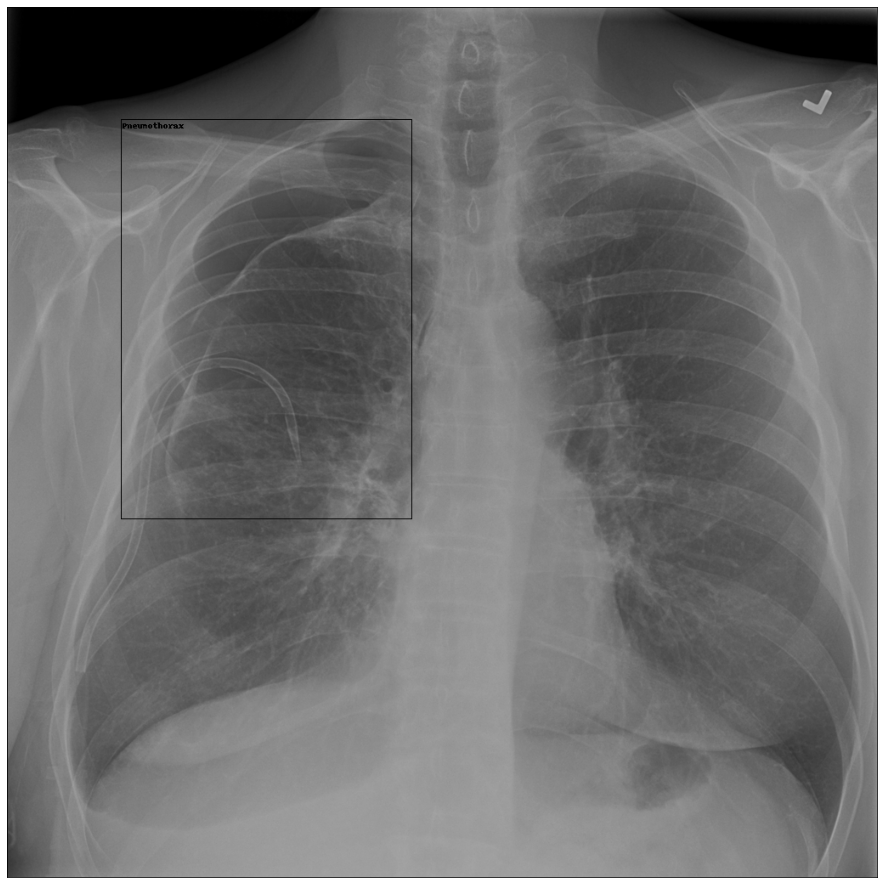

In [60]:
def show_boxes(image, boxes, names):
    drawn_boxes = draw_bounding_boxes(image, boxes, labels = names)

    plt.figure(figsize = (16, 16))
    plt.imshow(np.transpose(drawn_boxes, (1, 2, 0)))
    plt.tick_params(labelbottom = False, labelleft = False, bottom = False, left = False)
    plt.show()

dataiter = iter(train_loader)
image, target = next(dataiter)
print(target)

print(image)
image = image[0]
image = (image * 255).to(torch.uint8) 

boxes = target["boxes"][0]

labels = target["labels"][0]
names = [index2name[label.item()] for label in labels]

show_boxes(image, boxes, names)

# Import RetinaNet

In [61]:
import math
model = torchvision.models.detection.retinanet_resnet50_fpn(pretrained = True)

num_classes = len(index2name) + 1
num_anchors = model.head.classification_head.num_anchors

model.head.classification_head.num_classes = num_classes

cls_logits = torch.nn.Conv2d(256, num_anchors * num_classes, kernel_size = 3, stride = 1, padding = 1)
torch.nn.init.normal_(cls_logits.weight, std = 0.01)
torch.nn.init.constant_(cls_logits.bias, -math.log((1 - 0.01) / 0.01))
model.head.classification_head.cls_logits = cls_logits

for p in model.parameters():
    p.requires_grad = False

for p in model.head.classification_head.parameters():
    p.requires_grad = True

for p in model.head.regression_head.parameters():
    p.requires_grad = True

model.cuda()

Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth


  0%|          | 0.00/130M [00:00<?, ?B/s]

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)


In [62]:
model.backbone.body.conv1

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [63]:
model.backbone.body.conv1.in_channels

3

In [64]:
# The data images are black and white!
model.backbone.body.conv1.in_channels = 1

In [65]:
model.backbone.body.conv1

Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [66]:
model.cuda()

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)


# Training and Validation with RetinaNet

In [67]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr = 0.005, momentum = 0.9, weight_decay = 0.0005)
epoch_number = []
train_losses = []
val_losses = []
model.train()
patience = 0
epochs = 15
batch_size = 10
loss_list = []
for epoch in range(epochs):
    
    train_loss = 0
    for i, (images, targets) in enumerate(train_loader):
        losses = 0
        for j in range(len(images)):

            image = images[j].unsqueeze(0).cuda()

            boxes = targets["boxes"][j].cuda()
            labels = targets["labels"][j].cuda()
            target = [{"boxes":boxes, "labels":labels}]

            loss_dic = model(image, target)
            loss = sum(loss for loss in loss_dic.values())
            losses += loss
            train_loss += loss.item()
            loss_list.append(loss)
            
        losses /= batch_size
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if i % 10 == 9:
            print("epoch:", epoch + 1,  "iteration:", i + 1,  "loss:", loss.item()) 
    train_losses.append(train_loss / ((i + 1) * batch_size))        
    print("train_loss:", train_loss / ((i + 1) * batch_size))

    val_loss = 0
    for i, (image, target) in enumerate(val_loader):

        image = image.cuda()

        boxes = target["boxes"][0].cuda()
        labels = target["labels"][0].cuda()
        target = [{"boxes":boxes, "labels":labels}]

        loss_dic = model(image, target)
        loss = sum(loss for loss in loss_dic.values())
        val_loss += loss.item()
    val_losses.append(val_loss / len(val))   
    print("val_loss:", val_loss / len(val))
    epoch_number.append(epoch + 1)
    if min(val_losses) < val_loss / len(val):
        patience += 1
                          
    if patience == 2:
        break

epoch: 1 iteration: 10 loss: 1.1998686790466309
epoch: 1 iteration: 20 loss: 1.6589620113372803
epoch: 1 iteration: 30 loss: 1.784560203552246
epoch: 1 iteration: 40 loss: 1.2528334856033325
epoch: 1 iteration: 50 loss: 2.22542667388916
epoch: 1 iteration: 60 loss: 0.6390340328216553
epoch: 1 iteration: 70 loss: 1.0217517614364624
epoch: 1 iteration: 80 loss: 1.3061391115188599
epoch: 1 iteration: 90 loss: 1.3843181133270264
train_loss: 1.515322484307819
val_loss: 1.4176979552615772
epoch: 2 iteration: 10 loss: 0.5101562142372131
epoch: 2 iteration: 20 loss: 1.2020683288574219
epoch: 2 iteration: 30 loss: 1.5930569171905518
epoch: 2 iteration: 40 loss: 1.218834638595581
epoch: 2 iteration: 50 loss: 2.2073726654052734
epoch: 2 iteration: 60 loss: 0.5898504257202148
epoch: 2 iteration: 70 loss: 0.9004338979721069
epoch: 2 iteration: 80 loss: 1.0870392322540283
epoch: 2 iteration: 90 loss: 1.2708499431610107
train_loss: 1.315818603667948
val_loss: 1.3568032091314142
epoch: 3 iteration: 10

In [68]:
# loss_list

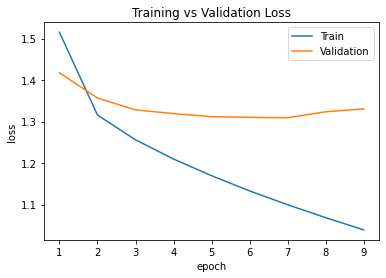

In [69]:
plt.plot(epoch_number, train_losses, label = "Training Loss")
plt.plot(epoch_number, val_losses, label = "Validation Loss")
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.title("Training vs Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')

plt.show()

# Inference with the Test Dataset

[{'boxes': tensor([[204.6830, 459.8662, 709.2844, 922.2584],
        [785.8072, 264.3607, 928.8928, 627.0911],
        [134.8038, 640.8987, 362.7400, 806.0012],
        ...,
        [152.2071, 596.9478, 290.2095, 667.4556],
        [155.3193, 173.0307, 382.9267, 269.2867],
        [549.9970, 795.6208, 685.3072, 883.8201]], device='cuda:0',
       grad_fn=<StackBackward0>), 'scores': tensor([0.1688, 0.1649, 0.1570, 0.1492, 0.1487, 0.1424, 0.1399, 0.1388, 0.1378,
        0.1372, 0.1372, 0.1347, 0.1347, 0.1232, 0.1221, 0.1187, 0.1171, 0.1167,
        0.1112, 0.1075, 0.1062, 0.1027, 0.1019, 0.1008, 0.0997, 0.0994, 0.0979,
        0.0978, 0.0962, 0.0962, 0.0949, 0.0945, 0.0945, 0.0940, 0.0927, 0.0917,
        0.0916, 0.0913, 0.0913, 0.0912, 0.0906, 0.0904, 0.0901, 0.0899, 0.0895,
        0.0887, 0.0874, 0.0874, 0.0863, 0.0862, 0.0859, 0.0852, 0.0843, 0.0842,
        0.0841, 0.0839, 0.0830, 0.0828, 0.0821, 0.0815, 0.0806, 0.0805, 0.0804,
        0.0793, 0.0793, 0.0791, 0.0790, 0.0790, 0.0789

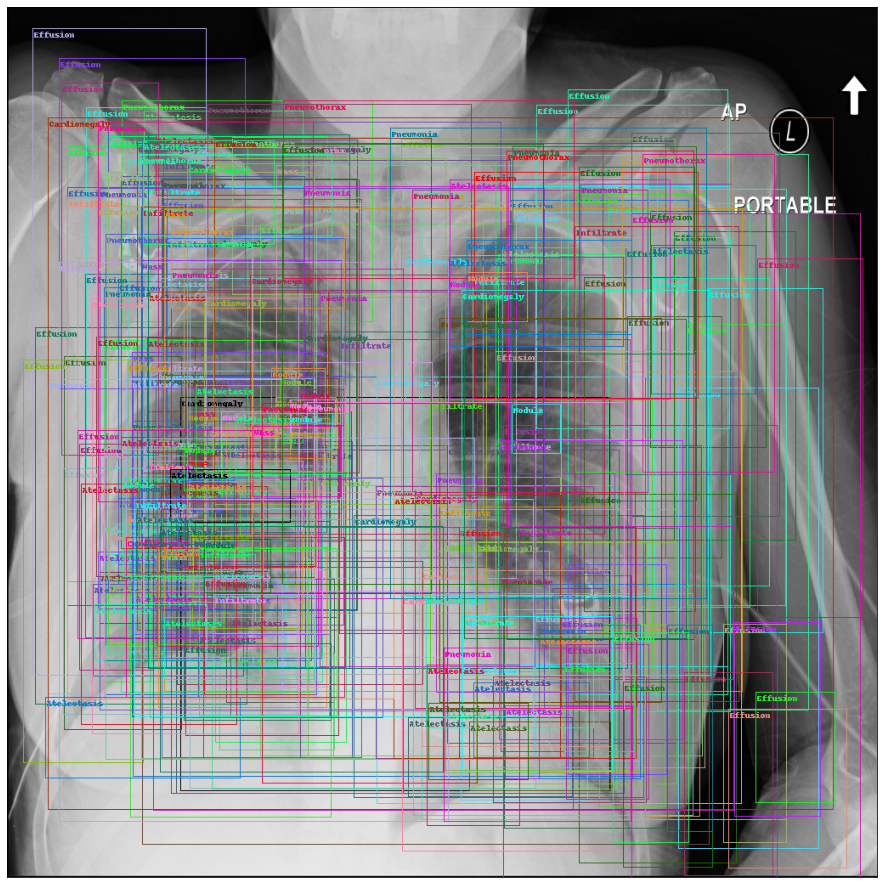

In [70]:
dataiter = iter(test_loader)
images, target = next(dataiter)

images = images.cuda()

model.eval()
predictions = model(images)
print(predictions)

image = (images[0] * 255).to(torch.uint8).cpu()
boxes = predictions[0]["boxes"].cpu()
labels = predictions[0]["labels"].cpu().detach().numpy()
labels = np.where(labels >= len(index2name), 0, labels)
names = [index2name[label.item()] for label in labels]

print(names)
show_boxes(image, boxes, names)

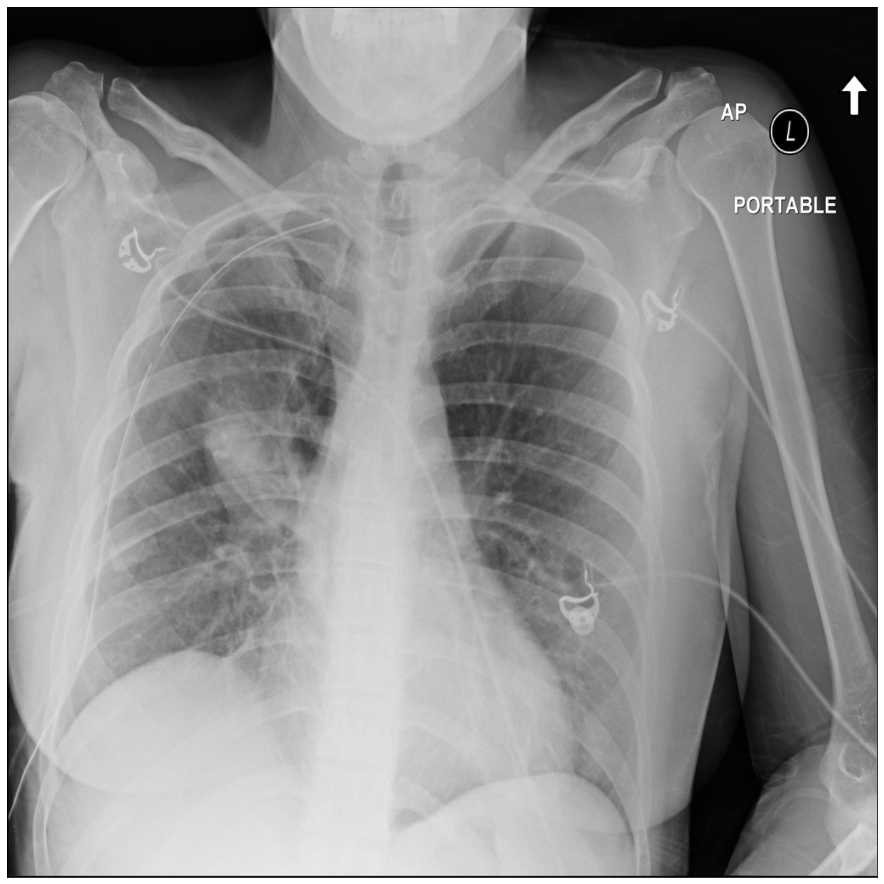

In [71]:
# Choose a box having the score more than 0.5.
boxes = []
names = []
for i, box in enumerate(predictions[0]["boxes"]):
    score = predictions[0]["scores"][i].cpu().detach().numpy()
    if score > 0.5:
        boxes.append(box.cpu().tolist())
        label = predictions[0]["labels"][i].item()
        if label >= len(index2name):
            label = 0
        name = index2name[label]
        names.append(name)
boxes = torch.tensor(boxes)

show_boxes(image, boxes, names)

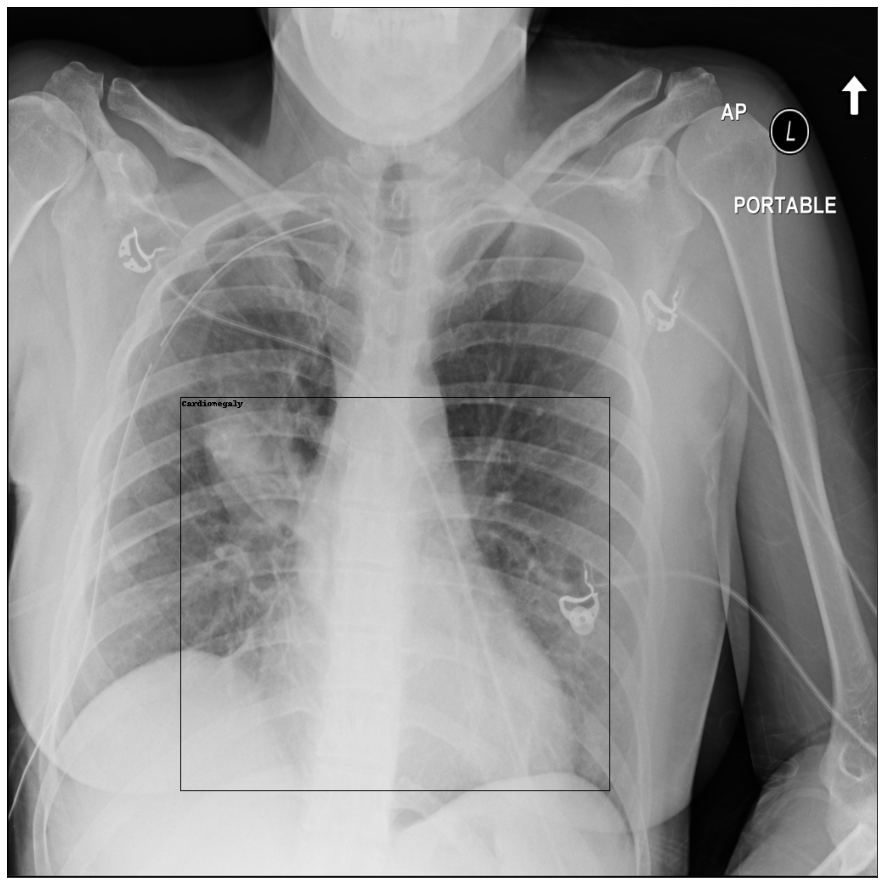

In [72]:
# Choose a boxe having the maximum score.
scores = []
boxes = []
names = []
for i, box in enumerate(predictions[0]["boxes"]):
    score = predictions[0]["scores"][i].cpu().detach().numpy()
    scores.append(score)
    
    if score == max(scores):
        boxes.append(box.cpu().tolist())
        label = predictions[0]["labels"][i].item()
        if label >= len(index2name):
            label = 0
        name = index2name[label]
        names.append(name)
boxes = torch.tensor(boxes)

show_boxes(image, boxes, names)

In [73]:
images

tensor([[[[0.0000, 0.0039, 0.0157,  ..., 0.0157, 0.0157, 0.0157],
          [0.0000, 0.0078, 0.0235,  ..., 0.0275, 0.0275, 0.0275],
          [0.0000, 0.0078, 0.0235,  ..., 0.0275, 0.0275, 0.0275],
          ...,
          [0.0000, 0.0275, 0.0902,  ..., 0.7137, 0.7020, 0.7294],
          [0.0000, 0.0392, 0.1294,  ..., 0.5529, 0.5608, 0.5804],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0157, 0.0275, 0.0275,  ..., 0.0863, 0.0941, 0.0549],
          [0.0353, 0.0549, 0.0588,  ..., 0.1765, 0.1882, 0.1137],
          [0.0353, 0.0549, 0.0549,  ..., 0.1725, 0.1804, 0.1059],
          ...,
          [0.3412, 0.6000, 0.5804,  ..., 0.0510, 0.0588, 0.0353],
          [0.3490, 0.6157, 0.5961,  ..., 0.0510, 0.0588, 0.0353],
          [0.1686, 0.2980, 0.2863,  ..., 0.0235, 0.0275, 0.0196]]],


        [[[0.0078, 0.0157, 0.0118,  ..., 0.0078, 0.0078, 0.0039],
          [0.0157, 0.0314, 0.0314,  ..., 0.0157, 0.0157, 0.0078],
          [0.0157, 0.0314, 0.0275,  ..

In [74]:
target

{'boxes': tensor([[[209.1344, 439.9407, 355.4201, 634.9883]],
 
         [[339.1661, 119.1958, 511.4582, 470.2815]],
 
         [[480.0339, 425.8540, 700.0042, 795.3608]],
 
         [[412.8508, 468.1143, 961.1513, 969.8201]],
 
         [[749.2267, 615.8602, 847.0756, 722.8113]],
 
         [[711.9238, 537.4645, 804.0296, 618.7344]],
 
         [[206.9672, 237.3079, 413.9344, 439.9407]],
 
         [[203.0933, 209.6735, 447.7155, 743.2913]],
 
         [[773.1200, 565.7979, 958.5778, 634.0646]],
 
         [[792.1100, 417.1852, 847.3735, 470.2815]],
 
         [[644.7407, 308.8254, 830.0359, 663.1619]],
 
         [[767.1873, 577.5577, 857.1259, 753.1005]],
 
         [[ 53.0963, 488.7026, 237.3079, 797.5280]],
 
         [[781.2740, 784.5248, 905.8878, 965.4857]],
 
         [[769.3545, 581.8921, 934.0614, 778.0233]],
 
         [[279.3244, 317.7624, 963.1289, 695.5046]],
 
         [[187.1644,  66.3135, 390.8267, 680.7135]],
 
         [[115.9450, 612.2328, 338.0826, 706.5058]],
 
 

In [75]:
"""
for i in range (24):
    print(f"Image{i}")
    image = (images[i] * 255).to(torch.uint8).cpu()
    boxes = predictions[i]["boxes"].cpu()
    labels = predictions[i]["labels"].cpu().detach().numpy()
    labels = np.where(labels >= len(index2name), 0, labels)
    names = [index2name[label.item()] for label in labels]

    print(names)
    show_boxes(image, boxes, names)
    
    scores = []
    boxes = []
    names = []
    for j, box in enumerate(predictions[i]["boxes"]):
        score = predictions[i]["scores"][j].cpu().detach().numpy()
        scores.append(score)

        if score == max(scores):
            boxes.append(box.cpu().tolist())
            label = predictions[i]["labels"][j].item()
            if label >= len(index2name):
                label = 0
            name = index2name[label]
            names.append(name)
    boxes = torch.tensor(boxes)

    show_boxes(image, boxes, names)
"""

'\nfor i in range (24):\n    print(f"Image{i}")\n    image = (images[i] * 255).to(torch.uint8).cpu()\n    boxes = predictions[i]["boxes"].cpu()\n    labels = predictions[i]["labels"].cpu().detach().numpy()\n    labels = np.where(labels >= len(index2name), 0, labels)\n    names = [index2name[label.item()] for label in labels]\n\n    print(names)\n    show_boxes(image, boxes, names)\n    \n    scores = []\n    boxes = []\n    names = []\n    for j, box in enumerate(predictions[i]["boxes"]):\n        score = predictions[i]["scores"][j].cpu().detach().numpy()\n        scores.append(score)\n\n        if score == max(scores):\n            boxes.append(box.cpu().tolist())\n            label = predictions[i]["labels"][j].item()\n            if label >= len(index2name):\n                label = 0\n            name = index2name[label]\n            names.append(name)\n    boxes = torch.tensor(boxes)\n\n    show_boxes(image, boxes, names)\n'

In [76]:
# dataiter = iter(test_loader)
# image, target = next(dataiter)

# image = image.cuda()

# model.eval()
# predictions = model(image)

# print(predictions)

In [77]:
"""
for i in range(24):
    img, _ = test[i]

    img = (img * 255).to(torch.uint8).cpu()
    img = img.numpy()

    img = np.transpose(img, (1, 2, 0))
    
    scores = []
    boxes = []
    names = []
    for j, box in enumerate(predictions[i]["boxes"]):
        score = predictions[i]["scores"][j].cpu().detach().numpy()
        scores.append(score)

        if score == max(scores):
            boxes.append(box.cpu().tolist())
            label = predictions[i]["labels"][j].item()
            if label >= len(index2name):
                label = 0
            name = index2name[label]
            names.append(name)
    boxes = torch.tensor(boxes)
    print(scores)
    print(boxes)
    print(names)
    print(label)
"""

'\nfor i in range(24):\n    img, _ = test[i]\n\n    img = (img * 255).to(torch.uint8).cpu()\n    img = img.numpy()\n\n    img = np.transpose(img, (1, 2, 0))\n    \n    scores = []\n    boxes = []\n    names = []\n    for j, box in enumerate(predictions[i]["boxes"]):\n        score = predictions[i]["scores"][j].cpu().detach().numpy()\n        scores.append(score)\n\n        if score == max(scores):\n            boxes.append(box.cpu().tolist())\n            label = predictions[i]["labels"][j].item()\n            if label >= len(index2name):\n                label = 0\n            name = index2name[label]\n            names.append(name)\n    boxes = torch.tensor(boxes)\n    print(scores)\n    print(boxes)\n    print(names)\n    print(label)\n'

In [78]:
# dataiter = iter(test_loader)
# image, target = next(dataiter)

# image = image.cuda()

# model.eval()
# predictions = model(image)
# print(predictions)

Object Detections in Chest X-Ray (Prediction for Test Data)


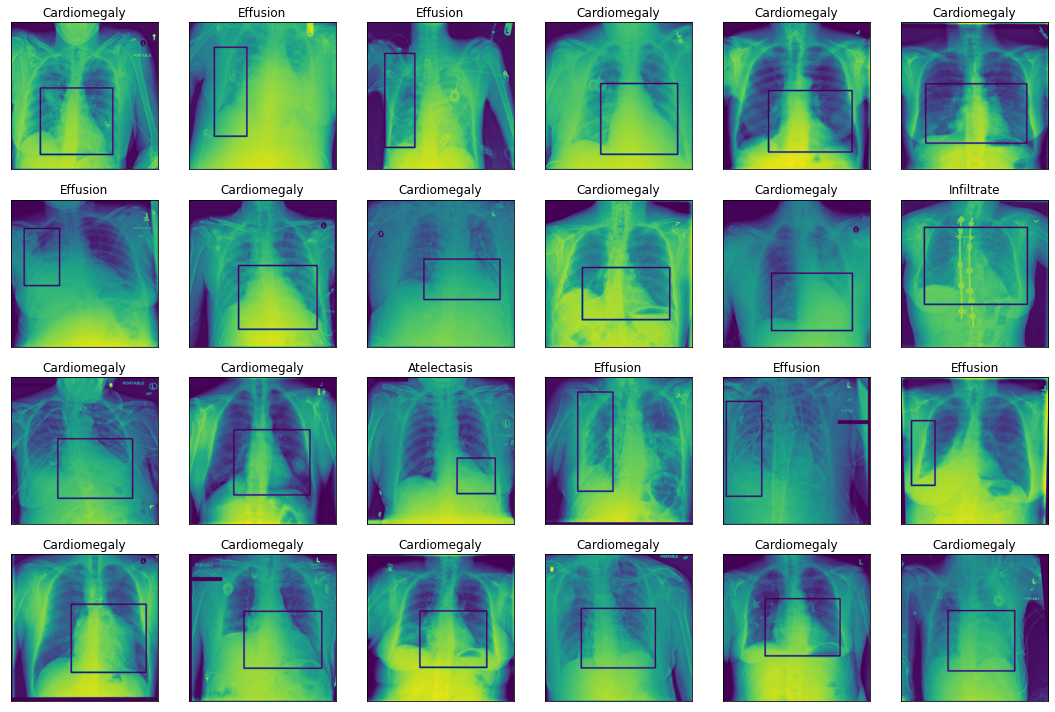

In [79]:
print("Object Detections in Chest X-Ray (Prediction for Test Data)")
fig, axes = plt.subplots(nrows = 4, ncols = 6, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img, _ = test[i]

    img = (img * 255).to(torch.uint8).cpu()
    img = img.numpy()

    img = np.transpose(img, (1, 2, 0))
    
            
    scores = []
    boxes = []
    names = []
    for j, box in enumerate(predictions[i]["boxes"]):
        score = predictions[i]["scores"][j].cpu().detach().numpy()
        scores.append(score)

        if score == max(scores):
            boxes.append(box.cpu().tolist())
            label = predictions[i]["labels"][j].item()
            if label >= len(index2name):
                label = 0
            name = index2name[label]
            names.append(name)
    boxes = torch.tensor(boxes)
    
    if names != []:

        cv2.rectangle(img, (int(boxes[0][0].item()),\
                            int(boxes[0][1].item())),\
                      (int(boxes[0][2].item()),\
                       int(boxes[0][3].item())),\
                      (0, 0, 0), 10)

    ax.imshow(img)
    
    if names != []:
        ax.set_title(names[0])
    else:
        ax.set_title("No Finding")

fig.tight_layout()    

plt.show()

Object Detections in Chest X-Ray (Prediction for Test Data)


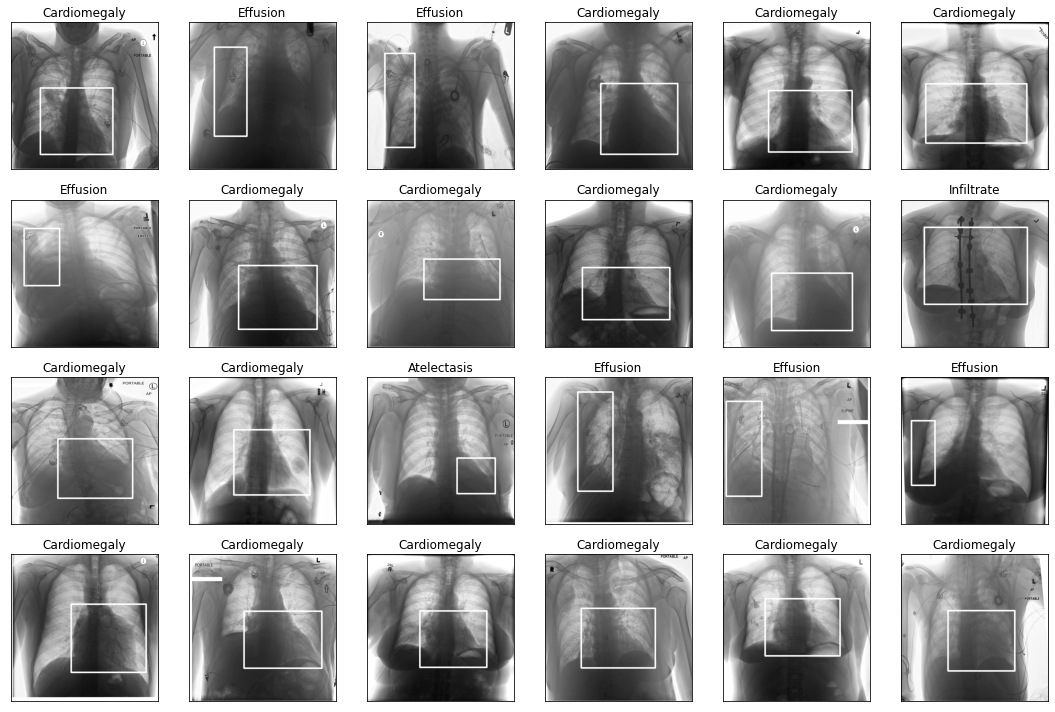

In [80]:
print("Object Detections in Chest X-Ray (Prediction for Test Data)")
fig, axes = plt.subplots(nrows = 4, ncols = 6, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img, _ = test[i]

    img = (img * 255).to(torch.uint8).cpu()
    img = img.numpy()

    img = np.transpose(img, (1, 2, 0))
    
            
    scores = []
    boxes = []
    names = []
    for j, box in enumerate(predictions[i]["boxes"]):
        score = predictions[i]["scores"][j].cpu().detach().numpy()
        scores.append(score)

        if score == max(scores):
            boxes.append(box.cpu().tolist())
            label = predictions[i]["labels"][j].item()
            if label >= len(index2name):
                label = 0
            name = index2name[label]
            names.append(name)
    boxes = torch.tensor(boxes)
    
    if names != []:

        cv2.rectangle(img, (int(boxes[0][0].item()),\
                            int(boxes[0][1].item())),\
                      (int(boxes[0][2].item()),\
                       int(boxes[0][3].item())),\
                      (0, 0, 0), 10)

    ax.imshow(img, cmap = 'gray_r')
    
    if names != []:
        ax.set_title(names[0])
    else:
        ax.set_title("No Finding")

fig.tight_layout()    

plt.show()

# Compare the Prediction with the Truth in the Test Data

Object Detections in Chest X-Ray (Truth for Test Data)


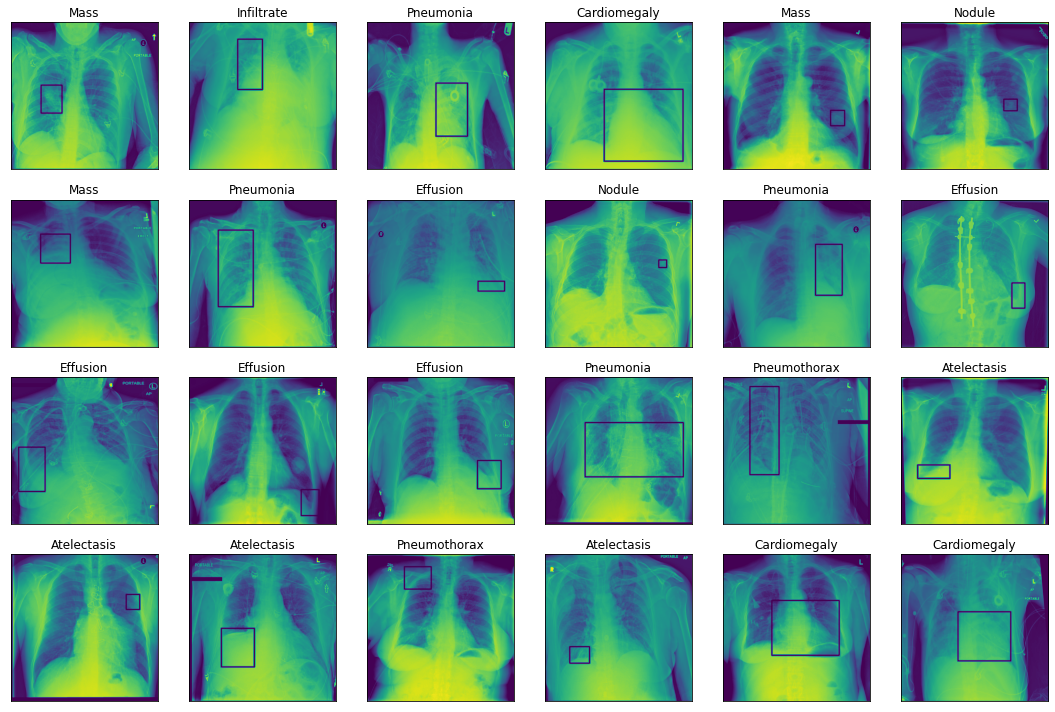

In [81]:
print("Object Detections in Chest X-Ray (Truth for Test Data)")
fig, axes = plt.subplots(nrows = 4, ncols = 6, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img, t = test[i]

    img = (img * 255).to(torch.uint8).cpu()
    img = img.numpy()

    img = np.transpose(img, (1, 2, 0))
    
    cv2.rectangle(img, (int(t["boxes"][0][0].item()),\
                        int(t["boxes"][0][1].item())),\
                  (int(t["boxes"][0][2].item()),\
                   int(t["boxes"][0][3].item())),\
                  (0, 0, 0), 10)
    

    ax.imshow(img)
    ax.set_title(index2name[int(t["labels"][0].item())])
fig.tight_layout()    

plt.show()

Object Detections in Chest X-Ray (Truth for Test Data)


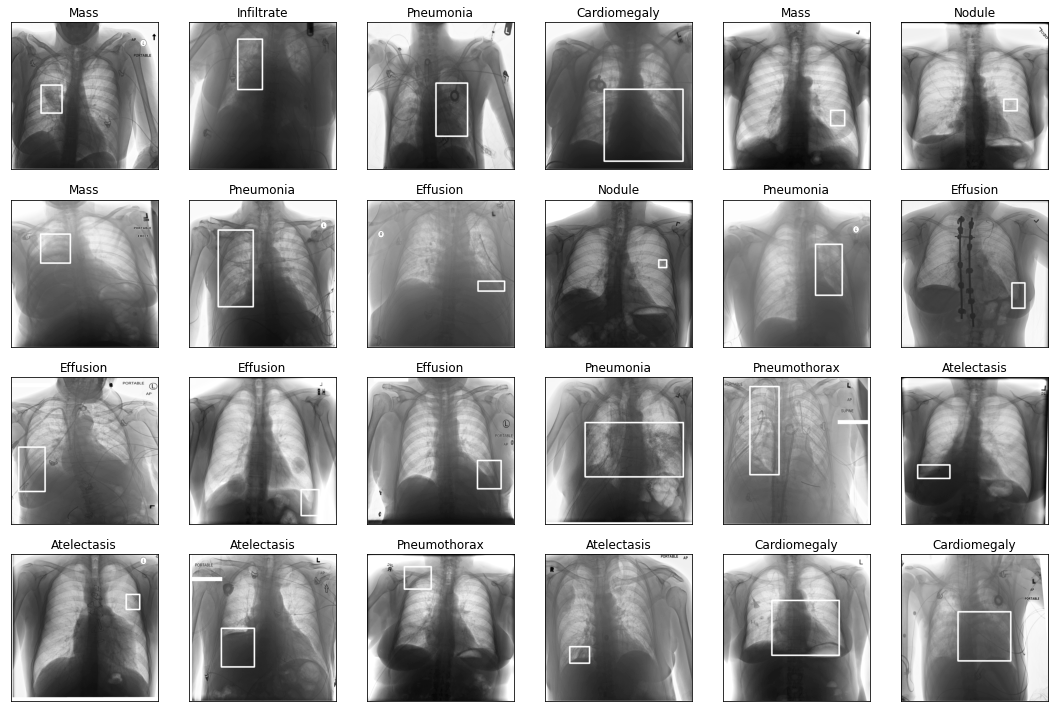

In [82]:
print("Object Detections in Chest X-Ray (Truth for Test Data)")
fig, axes = plt.subplots(nrows = 4, ncols = 6, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img, t = test[i]

    img = (img * 255).to(torch.uint8).cpu()
    img = img.numpy()

    img = np.transpose(img, (1, 2, 0))
    
    cv2.rectangle(img, (int(t["boxes"][0][0].item()),\
                        int(t["boxes"][0][1].item())),\
                  (int(t["boxes"][0][2].item()),\
                   int(t["boxes"][0][3].item())),\
                  (0, 0, 0), 10)
    

    ax.imshow(img, cmap = 'gray_r')
    ax.set_title(index2name[int(t["labels"][0].item())])
fig.tight_layout()    

plt.show()

In [83]:
dataiter = iter(test_loader)
image, target = next(dataiter)
print(target)

print(image)

{'boxes': tensor([[[209.1344, 439.9407, 355.4201, 634.9883]],

        [[339.1661, 119.1958, 511.4582, 470.2815]],

        [[480.0339, 425.8540, 700.0042, 795.3608]],

        [[412.8508, 468.1143, 961.1513, 969.8201]],

        [[749.2267, 615.8602, 847.0756, 722.8113]],

        [[711.9238, 537.4645, 804.0296, 618.7344]],

        [[206.9672, 237.3079, 413.9344, 439.9407]],

        [[203.0933, 209.6735, 447.7155, 743.2913]],

        [[773.1200, 565.7979, 958.5778, 634.0646]],

        [[792.1100, 417.1852, 847.3735, 470.2815]],

        [[644.7407, 308.8254, 830.0359, 663.1619]],

        [[767.1873, 577.5577, 857.1259, 753.1005]],

        [[ 53.0963, 488.7026, 237.3079, 797.5280]],

        [[781.2740, 784.5248, 905.8878, 965.4857]],

        [[769.3545, 581.8921, 934.0614, 778.0233]],

        [[279.3244, 317.7624, 963.1289, 695.5046]],

        [[187.1644,  66.3135, 390.8267, 680.7135]],

        [[115.9450, 612.2328, 338.0826, 706.5058]],

        [[802.9460, 281.7354, 896.13

In [84]:
"""
for i in range(24):
    print(f"Image{i}")
    dataiter = iter(test_loader)
    image, target = next(dataiter)

    image = image[i]
    image = (image * 255).to(torch.uint8) 

    boxes = target["boxes"][i]

    labels = target["labels"][i]
    names = [index2name[label.item()] for label in labels]

    show_boxes(image, boxes, names)
"""

'\nfor i in range(24):\n    print(f"Image{i}")\n    dataiter = iter(test_loader)\n    image, target = next(dataiter)\n\n    image = image[i]\n    image = (image * 255).to(torch.uint8) \n\n    boxes = target["boxes"][i]\n\n    labels = target["labels"][i]\n    names = [index2name[label.item()] for label in labels]\n\n    show_boxes(image, boxes, names)\n'

# Calculate Mean Average Precision (mAP)

In [85]:
boxes = []
scores = []
labels = []
for i in range(24):
    all_scores = []
    for j, box in enumerate(predictions[i]["boxes"]):
        score = predictions[i]["scores"][j].cpu().detach().numpy()
        all_scores.append(score)

        if score == max(all_scores):
            score = torch.tensor(score).item()
            scores.append(score)
            boxes.append(box.cpu().tolist())
            label = predictions[i]["labels"][j].item()
            if label >= len(index2name):
                label = 0
            labels.append(label)

print(boxes)
print(scores)
print(labels)

[[204.68299865722656, 459.8662414550781, 709.2843627929688, 922.2584228515625], [176.99163818359375, 175.8428497314453, 403.8310546875, 795.4500122070312], [124.81107330322266, 218.03921508789062, 333.2198486328125, 873.2673950195312], [388.3758544921875, 428.34381103515625, 924.3969116210938, 921.7785034179688], [317.892822265625, 477.5152282714844, 899.7938232421875, 905.42724609375], [171.348388671875, 430.8346862792969, 870.985107421875, 843.094970703125], [91.25432586669922, 198.82423400878906, 338.86376953125, 596.8317260742188], [345.82720947265625, 456.07061767578125, 892.259521484375, 900.8803100585938], [396.99761962890625, 411.217529296875, 926.6741943359375, 693.7830810546875], [260.19140625, 470.316162109375, 869.2145385742188, 833.3508911132812], [338.2395324707031, 509.7038879394531, 901.31982421875, 909.2059326171875], [161.62913513183594, 190.36618041992188, 874.8358154296875, 726.6100463867188], [326.17327880859375, 430.5640869140625, 847.4507446289062, 844.7802734375

In [86]:
preds = [
  dict(
    boxes = torch.tensor(boxes),
    scores = torch.tensor(scores),
    labels = torch.tensor(labels),
  )
]

In [87]:
dataiter = iter(test_loader)
_, target = next(dataiter)
print(target["boxes"].squeeze(1))
print(target["labels"].squeeze(1))

tensor([[209.1344, 439.9407, 355.4201, 634.9883],
        [339.1661, 119.1958, 511.4582, 470.2815],
        [480.0339, 425.8540, 700.0042, 795.3608],
        [412.8508, 468.1143, 961.1513, 969.8201],
        [749.2267, 615.8602, 847.0756, 722.8113],
        [711.9238, 537.4645, 804.0296, 618.7344],
        [206.9672, 237.3079, 413.9344, 439.9407],
        [203.0933, 209.6735, 447.7155, 743.2913],
        [773.1200, 565.7979, 958.5778, 634.0646],
        [792.1100, 417.1852, 847.3735, 470.2815],
        [644.7407, 308.8254, 830.0359, 663.1619],
        [767.1873, 577.5577, 857.1259, 753.1005],
        [ 53.0963, 488.7026, 237.3079, 797.5280],
        [781.2740, 784.5248, 905.8878, 965.4857],
        [769.3545, 581.8921, 934.0614, 778.0233],
        [279.3244, 317.7624, 963.1289, 695.5046],
        [187.1644,  66.3135, 390.8267, 680.7135],
        [115.9450, 612.2328, 338.0826, 706.5058],
        [802.9460, 281.7354, 896.1354, 386.8445],
        [225.0847, 517.7311, 455.0508, 786.7480],


In [88]:
target = [
  dict(
    boxes = target["boxes"].squeeze(1),
    labels = target["labels"].squeeze(1),
  )
]

In [89]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
metric = MeanAveragePrecision(task = "multiclass", num_classes = 9, average = None)
metric.update(preds, target)
from pprint import pprint
pprint(metric.compute())

{'map': tensor(0.0430),
 'map_50': tensor(0.1040),
 'map_75': tensor(0.0276),
 'map_large': tensor(0.0491),
 'map_medium': tensor(0.),
 'map_per_class': tensor(-1.),
 'map_small': tensor(-1.),
 'mar_1': tensor(0.0083),
 'mar_10': tensor(0.0750),
 'mar_100': tensor(0.0750),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.0857),
 'mar_medium': tensor(0.),
 'mar_small': tensor(-1.)}


# Save the Model

In [90]:
torch.save(model, 'object_detection_chestxray_pred_model.pth')

In [91]:
saved_model = torch.load('/kaggle/working/object_detection_chestxray_pred_model.pth')

In [92]:
saved_model

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)
